## INTRO & SETTINGS

The goal of this tutorial is to show the capabilities of `lf2i` and `Waldo` with a simple example: inferring the mean $\theta \in \mathbb{R}$ of a Gaussian model with fixed variance, and a Gaussian prior distribution

$$\theta \sim \mathcal{N}(0, 0.1), \\ \text{ } X|\theta \sim \mathcal{N}(\theta, 0.01)$$

In addition, we assume that we only observe one sample for each true $\theta$, i.e., $n=1$. \
For this tutorial, we leverage a prediction algorithm as the main underlying inferential model.

In [2]:
# SETTINGS

LIKELIHOOD_COV = 0.01
PRIOR_LOC = 0
PRIOR_COV = 0.1

PARAM_DIM = 1
DATA_DIM = 1
DATA_SAMPLE_SIZE = 1  # assume we get to see only one observed sample for each “true” parameter
PARAM_SPACE_BOUNDS = {'low': -1.5, 'high': 1.5}  # a grid of points over [low, high]^(param_dim) is used to construct confidence sets

CONFIDENCE_LEVEL = 0.95

## SIMULATE

Let's start from the simulator, which is used internally to generate the data needed to 
1. estimate the test statistics;
2. estimate the critical values; and 
3. diagnose the constructed confidence regions 

In [3]:
from lf2i.simulator.gaussian import GaussianMean

In [4]:
simulator = GaussianMean(
    likelihood_cov=LIKELIHOOD_COV,
    prior='gaussian',
    parameter_space_bounds=PARAM_SPACE_BOUNDS,
    param_grid_size=1000,
    param_dim=PARAM_DIM, 
    data_dim=DATA_DIM,
    data_sample_size=DATA_SAMPLE_SIZE,
    prior_kwargs={'loc': PRIOR_LOC, 'cov': PRIOR_COV}
)

#### Observations

For simplicity, let's use the simulator to get two “observed” samples from the true likelihood: one consistent with the prior ($\theta^{\star} = 0$) and one not ($\theta^{\star} = -1.45$)

In [5]:
import torch

true_param_consistent, true_param_notconsistent = torch.Tensor([0]), torch.Tensor([-1.45])
observed_x_consistent = simulator.likelihood(true_param_consistent).sample(sample_shape=(DATA_SAMPLE_SIZE, ))
observed_x_notconsistent = simulator.likelihood(true_param_notconsistent).sample(sample_shape=(DATA_SAMPLE_SIZE, ))

## CONFIDENCE SET by leveraging a PREDICTION ALGORITHM

Assume we want to do inference on the Gaussian mean by predicting its value given the data. `Waldo` allows to leverage any prediction algorithm to obtain a confidence region for the parameter of interest that is guaranteed to have the desired level of coverage regardless of 
1. the prior distribution;
2. the true value of the parameter;
3. the size of the observed sample

The prediction algorithm can be already trained or not. The example below assumes the algorithm (in this case GradientBoosting) has not been trained yet

In [6]:
from lf2i.inference.lf2i import WALDO
from lf2i.plot.parameter_regions import plot_parameter_region
from lf2i.utils.other_methods import central_prediction_sets

In [7]:
waldo = WALDO(
    simulator=simulator,
    estimator='mlp',  # for the conditional mean
    method='prediction',
    confidence_level=CONFIDENCE_LEVEL,
    conditional_variance_estimator='gb',  # for the conditional variance
    estimator_kwargs={'hidden_layer_sizes': (40, ), 'alpha': 0.1},
    cond_variance_estimator_kwargs={'n_estimators': 500, 'max_depth': 1}
)

In [8]:
confidence_region = waldo.infer(x=torch.vstack((observed_x_consistent, observed_x_notconsistent)), b=10_000, b_prime=5_000)

### Observation consistent with the prior

Waldo Confidence Region

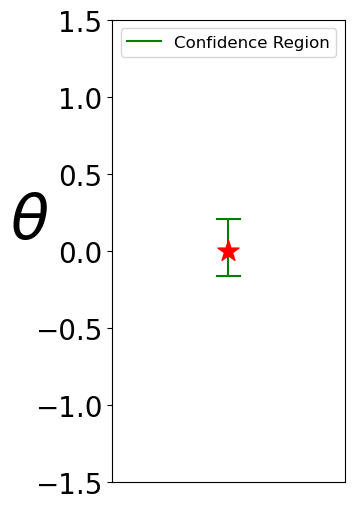

In [9]:
# The red star in the plot is the true parameter

plot_parameter_region(
    parameter_region=confidence_region[0],
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(3, 6)
)

Central (Gaussian approximation) prediction sets

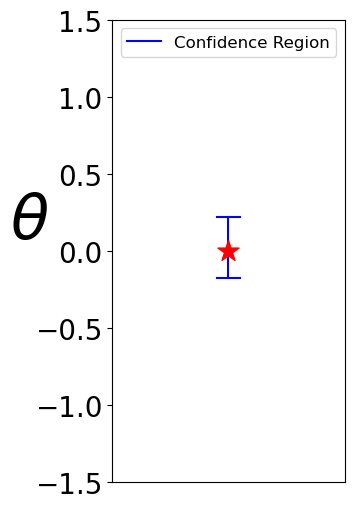

In [10]:
plot_parameter_region(
    parameter_region=central_prediction_sets(
        conditional_mean_estimator=waldo.test_statistic.estimator,
        conditional_variance_estimator=waldo.test_statistic.cond_variance_estimator,
        samples=observed_x_consistent,
        confidence_level=CONFIDENCE_LEVEL,
        param_dim=PARAM_DIM
    ),
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    color='blue',
    figsize=(3, 6)
)

### Observation *not* consistent with the prior

Waldo Confidence Region

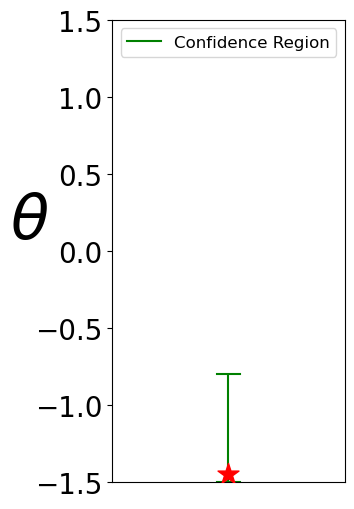

In [11]:
plot_parameter_region(
    parameter_region=confidence_region[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(3, 6)
)

Central (Gaussian approximation) prediction sets

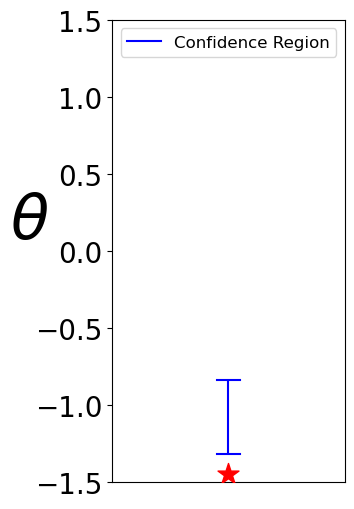

In [12]:
plot_parameter_region(
    parameter_region=central_prediction_sets(
        conditional_mean_estimator=waldo.test_statistic.estimator,
        conditional_variance_estimator=waldo.test_statistic.cond_variance_estimator,
        samples=observed_x_notconsistent,
        confidence_level=CONFIDENCE_LEVEL,
        param_dim=PARAM_DIM
    ),
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    color='blue',
    figsize=(3, 6)
)

## DIAGNOSTICS

In [13]:
from lf2i.plot.coverage_diagnostics import coverage_regions_plot

### Central (Gaussian approximation) Prediction Sets

In [14]:
parameters, mean_proba, upper_proba, lower_proba = waldo.diagnose(
    b_doubleprime=10_000,
    region_type='prediction'
)

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.



Coverage is close to the correct level (95%) only when the true parameter is close to the bulk of the prior distribution

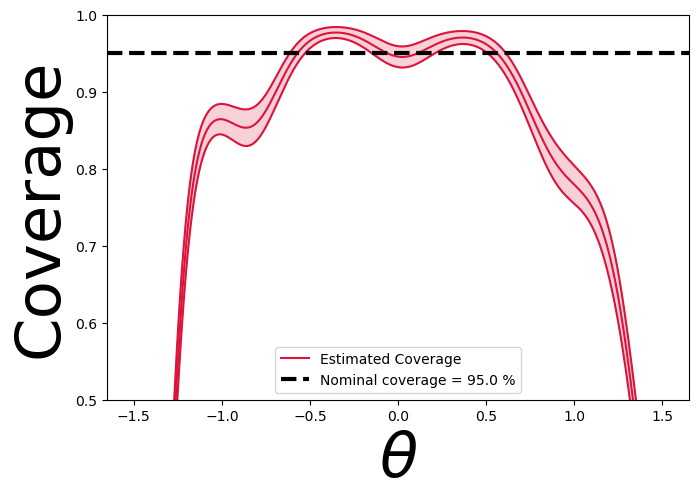

In [15]:
coverage_regions_plot(
    parameters=parameters,
    mean_proba=mean_proba, 
    upper_proba=upper_proba,
    lower_proba=lower_proba,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(7.5, 5),
    ylims=(0.5, 1)
)

### Waldo Confidence Regions

In [16]:
parameters, mean_proba, upper_proba, lower_proba = waldo.diagnose(
    b_doubleprime=10_000,
    region_type='lf2i'
)

Coverage is approximately the correct level (95%) everywhere

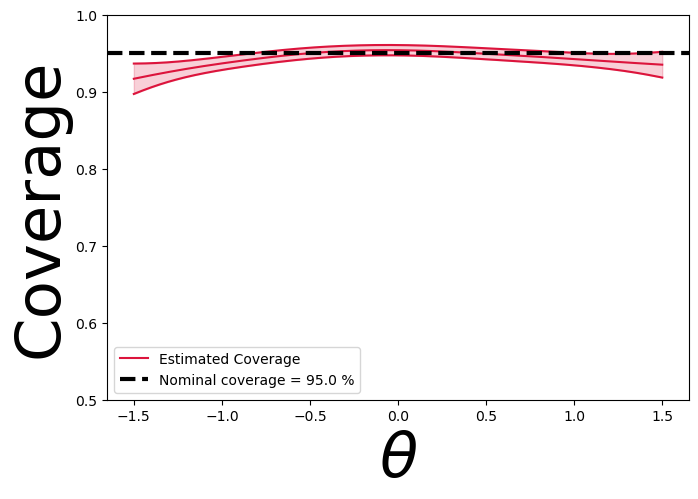

In [17]:
coverage_regions_plot(
    parameters=parameters,
    mean_proba=mean_proba, 
    upper_proba=upper_proba,
    lower_proba=lower_proba,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(7.5, 5),
    ylims=(0.5, 1)
)